In [1]:
!pip install -e ../.

Obtaining file:///Users/paul/Documents/Cours/MVA/RL/Projet/DeepCode/sunrise/Cheetah_exps
  Attempting uninstall: rlkit
    Found existing installation: rlkit 0.2.1.dev0
    Uninstalling rlkit-0.2.1.dev0:
      Successfully uninstalled rlkit-0.2.1.dev0
  Running setup.py develop for rlkit
You should consider upgrading via the '/Users/paul/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
from rlkit.envs.wrappers import NormalizedBoxEnv
from rlkit.torch.sac.policies import TanhGaussianPolicy
from rlkit.torch.sac.sac import SACTrainer
from rlkit.torch.networks import FlattenMlp
from gym.envs.mujoco import HalfCheetahEnv
import torch
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

## Get env and baseline policy

In [2]:
# Env
env =  NormalizedBoxEnv(HalfCheetahEnv())

/Users/paul/anaconda3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
def load_models(path, step, num_ensemble, policy, qf1, qf2):
    policy.load_state_dict(
            torch.load('%s/%d_th_actor_%s.pt' % (path, 0, step))
        )
    for en_index in range(num_ensemble):
        qf1[en_index].load_state_dict(
            torch.load('%s/%d_th_1st_critic_%s.pt' % (path, en_index, step))
        )
        qf2[en_index].load_state_dict(
            torch.load('%s/%d_th_2nd_critic_%s.pt' % (path, en_index, step))
        )

In [4]:
# Baseline hyperparameters
baseline_path = \
'../data/gym_cheetah/Conservative-SUNRISE/Conservative_SUNRISE_cons_False_alpha_ce_0.20_en_5_batch_256_layer_2_seed_1234/model'
# step = 100
BASELINE_NUM_ENSEMBLE = 5
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

M = 256
num_layer = 2
network_structure = [M] * num_layer

# Get baseline
L_baseline_policy = TanhGaussianPolicy(
        obs_dim=obs_dim,
        action_dim=action_dim,
        hidden_sizes=network_structure,
    )
L_baseline_qf1, L_baseline_qf2 = [], []
    
for _ in range(BASELINE_NUM_ENSEMBLE):

    baseline_qf1 = FlattenMlp(
        input_size=obs_dim + action_dim,
        output_size=1,
        hidden_sizes=network_structure,
    )
    baseline_qf2 = FlattenMlp(
        input_size=obs_dim + action_dim,
        output_size=1,
        hidden_sizes=network_structure,
    )

    L_baseline_qf1.append(baseline_qf1)
    L_baseline_qf2.append(baseline_qf2)
    

## Evaluate policy

In [5]:
from rlkit.samplers.rollout_functions import ensemble_rollout_one_policy, ensemble_rollout

In [7]:
episode_rewards = {}
for step in [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57]:
    # Load models
    load_models(baseline_path, 
                step, 
                BASELINE_NUM_ENSEMBLE, 
                L_baseline_policy, 
                L_baseline_qf1, 
                L_baseline_qf2)

    # Logs baseline
    episode_rewards[step] = []
    for _ in range(10):
        other_path = ensemble_rollout_one_policy(env, L_baseline_policy, BASELINE_NUM_ENSEMBLE, max_path_length=1000)
        episode_rewards[step].append(other_path['rewards'].sum())

episode_rewards 


{0: [-351.70462831624866,
  -182.84159738682908,
  -40.95076386693179,
  -186.24920034577576,
  -202.24809598681767,
  -323.24767942763617,
  -370.73025768839096,
  -147.25578682862132,
  -293.44047304248755,
  -342.08897049548705],
 3: [-241.87541921582414,
  -246.19533803361531,
  -194.0886403512166,
  -219.14989103077676,
  -147.59460257443453,
  -210.96935147653227,
  -242.36445432607724,
  -194.6035698958723,
  -171.5860203601345,
  -247.6866240215123],
 6: [-5.385319002629707,
  -10.58259994090805,
  -22.616641245273687,
  -16.912790014478478,
  -27.611836547716077,
  -68.30912792853678,
  58.84517519132559,
  21.433060505338133,
  -132.50628478337745,
  -59.80069409920171],
 9: [327.29977560454495,
  218.32908219827232,
  260.90103317096714,
  290.7369479023787,
  273.5383028811334,
  381.74366424300695,
  277.2480055648637,
  301.0288297282707,
  319.3013240872254,
  280.8748090904314],
 12: [278.7262638312127,
  338.4165492898771,
  297.50092056300696,
  254.3035113872442,
  3

## Retrieve data

In [7]:
path_normal = '../data/gym_cheetah/Conservative-SUNRISE/Conservative_SUNRISE_cons_False_alpha_ce_0.20_en_5_batch_256_layer_2_seed_1234'
path_cons = '../data/gym_cheetah/Conservative-SUNRISE/Conservative_SUNRISE_cons_True_alpha_ce_0.20_en_5_batch_256_layer_2_seed_4123'

df_normal = pd.read_csv(f'{path_normal}/progress.csv')
df_cons = pd.read_csv(f'{path_cons}/progress.csv')

## Plots

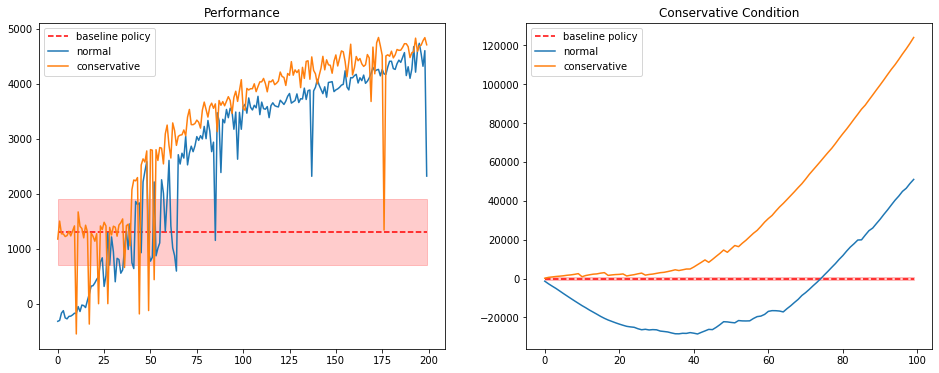

In [8]:
# Chosen step
n = max(len(df_normal['evaluation/Average Returns']), len(df_cons['evaluation/Average Returns']))
step = 40

plt.figure(figsize=(16,6))

############ Performance ############
#####################################
plt.subplot(1, 2, 1, title='Performance')

# Baseline
mean_rollout, std_rollout = np.mean(episode_rewards[step]['normal']), np.std(episode_rewards[step]['normal'])
plt.plot(np.ones(n)*mean_rollout, 'r', ls='--', label='baseline policy')
plt.fill_between(np.arange(0,n), 
                 mean_rollout - 3.5*std_rollout, 
                 mean_rollout + 3.5*std_rollout, 
                 alpha = 0.2, 
                 color='r'
                )

# Normal 
plt.plot(df_normal['evaluation/Average Returns'], label='normal')

# Conservative
plt.plot(df_cons['evaluation/Average Returns'], label='conservative')

plt.legend()

############ Condition ##############
#####################################
#####################################
plt.subplot(1, 2, 2, title='Conservative Condition')

plt.plot(np.arange(100), np.zeros(100), c='r', ls='--', label='baseline policy')
plt.fill_between(np.arange(0,100), 
                 0 - 3.5*std_rollout, 
                 0 + 3.5*std_rollout, 
                 alpha = 0.2, 
                 color='r'
                )

df_normal_100 = df_normal[:100]
df_cons_100 = df_cons[:100]

plt.plot( 
    df_normal_100['evaluation/Average Returns'].cumsum() \
                - 0.8*(np.ones(100)*mean_rollout).cumsum(), 
    label='normal'
    )
plt.plot(
    df_cons_100['evaluation/Average Returns'].cumsum() \
                - 0.8*(np.ones(100)*mean_rollout).cumsum(), 
    label='conservative',
    )

plt.legend()

plt.show()

## Multiple seeds

In [29]:
total_paths = glob.glob('../data/gym_cheetah/Conservative-SUNRISE/*')

paths_cons, paths_normal = [], []

for path in total_paths:
    if 'True' in path:
        paths_cons.append(path)

for path in total_paths:
    if 'False' in path:
        paths_normal.append(path)

In [32]:
# Create global dataframe for each seed
all_cons_df = {}
all_normal_df = {}
for path in paths_cons:
    seed = path.split('/')[-1].split('_')[-1]
    df_cons = pd.read_csv(f'{path}/progress.csv')
    all_cons_df[seed] = df_cons
for path in paths_normal:
    seed = path.split('/')[-1].split('_')[-1]
    df_normal = pd.read_csv(f'{path}/progress.csv')
    all_normal_df[seed] = df_normal
    
global_cons_df = pd.concat([all_cons_df[seed]['evaluation/Average Returns'].rename(seed) for seed in all_cons_df.keys()], axis=1)
global_normal_df = pd.concat([all_normal_df[seed]['evaluation/Average Returns'].rename(seed) for seed in all_normal_df.keys()], axis=1)


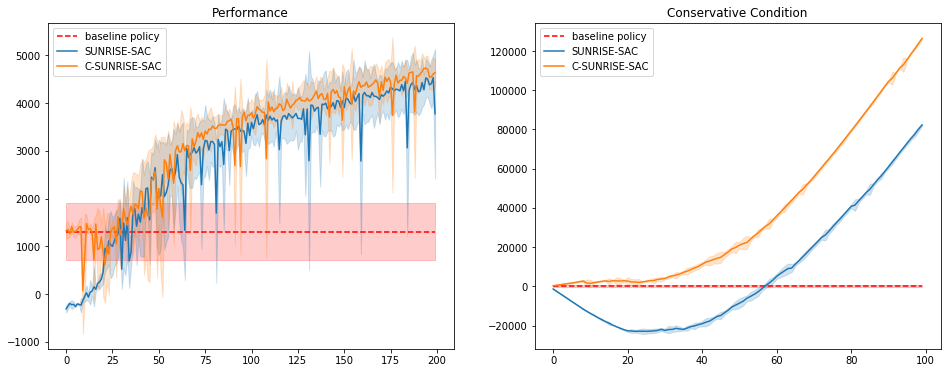

In [33]:
# Chosen step
n = max(len(df_normal['evaluation/Average Returns']), len(df_cons['evaluation/Average Returns']))
step = 40

plt.figure(figsize=(16,6))

############ Performance ############
#####################################
plt.subplot(1, 2, 1, title='Performance')

# Baseline
mean_rollout, std_rollout = np.mean(episode_rewards[step]['normal']), np.std(episode_rewards[step]['normal'])
plt.plot(np.ones(n)*mean_rollout, 'r', ls='--', label='baseline policy')
plt.fill_between(np.arange(0,n), 
                 mean_rollout - 3.5*std_rollout, 
                 mean_rollout + 3.5*std_rollout, 
                 alpha = 0.2, 
                 color='r'
                )

# Normal 
plt.plot(global_normal_df.mean(axis=1), label='SUNRISE-SAC')
plt.fill_between(np.arange(0,200), 
                 global_normal_df.mean(axis=1) - 1*global_normal_df.std(axis=1), 
                 global_normal_df.mean(axis=1) + 1*global_normal_df.std(axis=1), 
                 alpha = 0.2, 
                 color='tab:blue'
                )

# Conservative
plt.plot(global_cons_df.mean(axis=1), label='C-SUNRISE-SAC')
plt.fill_between(np.arange(0,200), 
                 global_cons_df.mean(axis=1) - 1*global_cons_df.std(axis=1), 
                 global_cons_df.mean(axis=1) + 1*global_cons_df.std(axis=1), 
                 alpha = 0.2, 
                 color='tab:orange'
                )

plt.legend()

############ Condition ##############
#####################################
#####################################
plt.subplot(1, 2, 2, title='Conservative Condition')

plt.plot(np.arange(100), np.zeros(100), c='r', ls='--', label='baseline policy')
plt.fill_between(np.arange(0,100), 
                 0 - 3.5*std_rollout, 
                 0 + 3.5*std_rollout, 
                 alpha = 0.2, 
                 color='r'
                )

global_normal_100 = global_normal_df[:100]
global_cons_100 = global_cons_df[:100][:100]

plt.plot( 
    global_normal_100.mean(axis=1).cumsum() \
                - 0.8*(np.ones(100)*mean_rollout).cumsum(), 
    label='SUNRISE-SAC'
    )
plt.fill_between(np.arange(0,100), 
                 global_normal_100.mean(axis=1).cumsum() - 0.8*(np.ones(100)*mean_rollout).cumsum() \
                     - 2*global_normal_100.std(axis=1), 
                 global_normal_100.mean(axis=1).cumsum() - 0.8*(np.ones(100)*mean_rollout).cumsum() \
                     + 2*global_normal_100.std(axis=1), 
                 alpha = 0.2, 
                 color='tab:blue'
                )
plt.plot(
    global_cons_100.mean(axis=1).cumsum() \
                - 0.8*(np.ones(100)*mean_rollout).cumsum(), 
    label='C-SUNRISE-SAC',
    )
plt.fill_between(np.arange(0,100), 
                 global_cons_100.mean(axis=1).cumsum() - 0.8*(np.ones(100)*mean_rollout).cumsum() \
                     - 2*global_cons_100.std(axis=1), 
                 global_cons_100.mean(axis=1).cumsum() - 0.8*(np.ones(100)*mean_rollout).cumsum() \
                     + 2*global_cons_100
                 .std(axis=1), 
                 alpha = 0.2, 
                 color='tab:orange'
                )

plt.legend()

plt.show()

## Fail-Safe

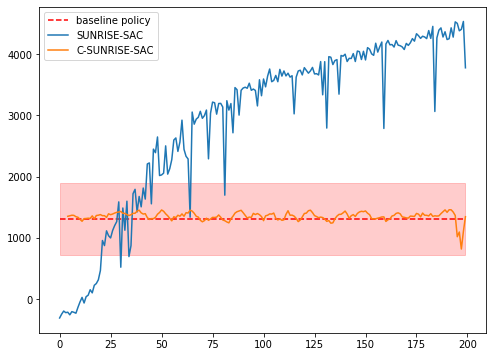

In [39]:
path_fail = '../data/gym_cheetah/Conservative-SUNRISE/distributional_shift'

plt.figure(figsize=(8,6))

# Baseline Policy
mean_rollout, std_rollout = np.mean(episode_rewards[step]['normal']), np.std(episode_rewards[step]['normal'])
plt.plot(np.ones(n)*mean_rollout, 'r', ls='--', label='baseline policy')
plt.fill_between(np.arange(0,n), 
                 mean_rollout - 3.5*std_rollout, 
                 mean_rollout + 3.5*std_rollout, 
                 alpha = 0.2, 
                 color='r'
                )

# Baseline policy
plt.plot(global_normal_df.mean(axis=1), label='SUNRISE-SAC')

# Failsafe
df_fail = pd.read_csv(f'{path_fail}/progress.csv')
plt.plot(df_fail['evaluation/Average Returns'].rolling(window=5).mean(), color='tab:orange', label='C-SUNRISE-SAC')

plt.legend()

plt.show()

## Hopper env

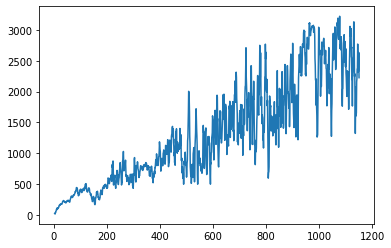

In [8]:
path_normal = '../data/gym_hopper/Conservative-SUNRISE/Conservative_SUNRISE_cons_False_alpha_ce_0.20_en_5_batch_256_layer_2_seed_1234'
# path_cons = '../data/gym_cheetah/Conservative-SUNRISE/Conservative_SUNRISE_cons_True_alpha_ce_0.20_en_5_batch_256_layer_2_seed_4123'

df_normal = pd.read_csv(f'{path_normal}/progress.csv')

plt.plot(df_normal['evaluation/Average Returns'].rolling(window=5).mean())


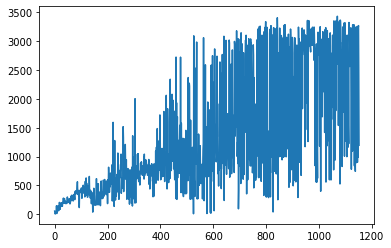

In [12]:
plt.plot(df_normal['evaluation/Average Returns'])

In [22]:
from matplotlib.legend_handler import HandlerTuple

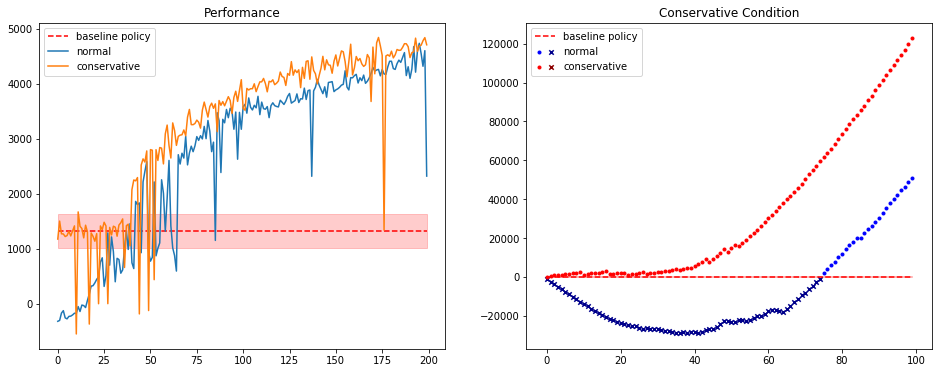

In [52]:
# Chosen step
n = max(len(df_normal['evaluation/Average Returns']), len(df_cons['evaluation/Average Returns']))
step = 40

plt.figure(figsize=(16,6))

############ Performance ############
#####################################
plt.subplot(1, 2, 1, title='Performance')

# Baseline
mean_rollout, std_rollout = np.mean(episode_rewards[step]['normal']), np.std(episode_rewards[step]['normal'])
plt.plot(np.ones(n)*mean_rollout, 'r', ls='--', label='baseline policy')
plt.fill_between(np.arange(0,n), 
                 mean_rollout - 3.5*std_rollout, 
                 mean_rollout + 3.5*std_rollout, 
                 alpha = 0.2, 
                 color='r'
                )

# Normal 
plt.plot(df_normal['evaluation/Average Returns'], label='normal')

# Conservative
plt.plot(df_cons['evaluation/Average Returns'], label='conservative')

plt.legend()

############ Condition ##############
#####################################
#####################################
ax = plt.subplot(1, 2, 2, title='Conservative Condition')

p_1 = ax.plot(np.arange(100), np.zeros(100), c='r', ls='--')
p_2 = ax.fill_between(np.arange(0,100), 
                 0 - 3.5*std_rollout, 
                 0 + 3.5*std_rollout, 
                 alpha = 0.2, 
                 color='r'
                )

df_normal_100 = df_normal[:100]
df_cons_100 = df_cons[:100]

n_1 = ax.scatter(
        df_normal_100.loc[df_normal_100['evaluation/Average Returns'].cumsum() \
            - 0.8*(np.ones(df_normal_100.shape[0])*mean_rollout).cumsum() >=0, 'Epoch'], 
        df_normal_100.loc[df_normal_100['evaluation/Average Returns'].cumsum() \
            - 0.8*(np.ones(df_normal_100.shape[0])*mean_rollout).cumsum() >=0, \
                'evaluation/Average Returns'].cumsum() \
                    - 0.8*(np.ones(df_normal_100.loc[df_normal_100['evaluation/Average Returns'].cumsum() \
                        - 0.8*(np.ones(df_normal_100.shape[0])*mean_rollout).cumsum() >=0, :].shape[0])\
                            *mean_rollout).cumsum(), 
        marker='.',
        color='blue'
        )
n_2 = ax.scatter(
        df_normal_100.loc[df_normal_100['evaluation/Average Returns'].cumsum() \
            - 0.8*(np.ones(df_normal_100.shape[0])*mean_rollout).cumsum() <0, 'Epoch'], 
        df_normal_100.loc[df_normal_100['evaluation/Average Returns'].cumsum() \
            - 0.8*(np.ones(df_normal_100.shape[0])*mean_rollout).cumsum() <0, \
                'evaluation/Average Returns'].cumsum() \
                    - 0.8*(np.ones(df_normal_100.loc[df_normal_100['evaluation/Average Returns'].cumsum() \
                        - 0.8*(np.ones(df_normal_100.shape[0])*mean_rollout).cumsum() <0, :].shape[0])\
                            *mean_rollout).cumsum(), 
        marker='x',
        s=20,
        color='darkblue'
        )
c_1 = ax.scatter(df_cons_100.loc[df_cons_100['evaluation/Average Returns'].cumsum() \
                - 0.8*(np.ones(df_cons_100.shape[0])*mean_rollout).cumsum() >=0, 'Epoch'], 
            df_cons_100.loc[df_cons_100['evaluation/Average Returns'].cumsum() \
                - 0.8*(np.ones(df_cons_100.shape[0])*mean_rollout).cumsum() >=0, \
                    'evaluation/Average Returns'].cumsum() \
                         - 0.8*(np.ones(df_cons_100.loc[df_cons_100['evaluation/Average Returns'].cumsum() \
                            - 0.8*(np.ones(df_normal_100.shape[0])*mean_rollout).cumsum() >=0, :].shape[0])\
                                *mean_rollout).cumsum(), 
            marker='.',
            color='red'
            )
c_2 = ax.scatter(df_cons_100.loc[df_cons_100['evaluation/Average Returns'].cumsum() \
                - 0.8*(np.ones(df_cons_100.shape[0])*mean_rollout).cumsum() <0, 'Epoch'], 
            df_cons_100.loc[df_cons_100['evaluation/Average Returns'].cumsum() \
                - 0.8*(np.ones(df_cons_100.shape[0])*mean_rollout).cumsum() <0, \
                    'evaluation/Average Returns'].cumsum() \
                         - 0.8*(np.ones(df_cons_100.loc[df_cons_100['evaluation/Average Returns'].cumsum() \
                            - 0.8*(np.ones(df_normal_100.shape[0])*mean_rollout).cumsum() <0, :].shape[0])\
                                *mean_rollout).cumsum(), 
            marker='x',
            s=20,
            color='darkred'
            )
l = ax.legend([p_1[0], (n_1, n_2), (c_1, c_2)], ['baseline policy', 'normal', 'conservative'],
              handler_map={tuple: HandlerTuple(ndivide=None)})

# ax.legend()

plt.show()